In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Read in the cleaned data from basin_char_eda.ipynb
master_df = pd.read_parquet('../data/cleaned_df.parquet')
master_df.head()

,DRAIN_SQKM,HYDRO_DISTURB_INDX,WD_BASIN,SNOW_PCT_PRECIP,PRECIP_SEAS_IND,STREAMS_KM_SQ_KM,MAINSTEM_SINUOUSITY,TOPWET,RUNAVE7100,PCT_1ST_ORDER,PCT_6TH_ORDER_OR_MORE,NDAMS_2009,CANALS_PCT,PCT_IRRIG_AG,HIRES_LENTIC_DENS,HIRES_LENTIC_MEANSIZ,CLAYAVE,SILTAVE,SANDAVE,leadtime,rsr,perf_cat,is_ref
site_no,,,,,,,,,,,,,,,,,,,,,,,
01011000,3186.8,8.0,133.4,37.5,0.11,0.57,1.53,11.5,484.4,62.27,0.0,2.0,0.0,0.0,0.231,177.2,18.36,59.77,21.87,1.0,0.07,good,0
01011000,3186.8,8.0,133.4,37.5,0.11,0.57,1.53,11.5,484.4,62.27,0.0,2.0,0.0,0.0,0.231,177.2,18.36,59.77,21.87,2.0,0.35,good,0
01011000,3186.8,8.0,133.4,37.5,0.11,0.57,1.53,11.5,484.4,62.27,0.0,2.0,0.0,0.0,0.231,177.2,18.36,59.77,21.87,3.0,0.41,good,0
01011000,3186.8,8.0,133.4,37.5,0.11,0.57,1.53,11.5,484.4,62.27,0.0,2.0,0.0,0.0,0.231,177.2,18.36,59.77,21.87,4.0,0.38,good,0
01011000,3186.8,8.0,133.4,37.5,0.11,0.57,1.53,11.5,484.4,62.27,0.0,2.0,0.0,0.0,0.231,177.2,18.36,59.77,21.87,5.0,0.50,good,0


# Random Forest
The following section fits a random forest model using basin characteristics as features and `perf_cat` label as target. A forecast is labeled `good` if the RSR value of the forecast at a given leadtime is > 0.7.

The goal of this exercise is two fold:
1) Examine the feature importances as a functino of leadtime
2) Predict class of a forecast based solely off of basin characteristics.

## Build classifier model
### Import libraries

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Prepare data

In [4]:
features = master_df.loc[:,master_df.columns != 'perf_cat']
features = features.loc[:,features.columns != 'leadtime']
features = features.loc[:,features.columns != 'rsr']

labels = master_df['perf_cat']

In [5]:
train_features, test_features, train_labels, test_labels = train_test_split(features,
                                                                            labels,
                                                                            test_size=0.3,
                                                                            random_state=42)

In [6]:
print('Train features dims: ' + str(train_features.shape))
print('Test features dims: ' + str(test_features.shape))
print('Train labels dims: ' + str(train_labels.shape))
print('Test labels dims: ' + str(test_labels.shape))

Train features dims: (71390, 20)
Test features dims: (30597, 20)
Train labels dims: (71390,)
Test labels dims: (30597,)


In [7]:
clf = RandomForestClassifier(n_jobs=4,random_state=42, n_estimators=100)
clf.fit(train_features,train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [8]:
feature_imp = pd.DataFrame(list(zip(train_features.columns,clf.feature_importances_)),columns=['feature','value'])
feature_imp.sort_values(by='value',ascending=False)

,feature,value
0,DRAIN_SQKM,0.123907
11,NDAMS_2009,0.104699
2,WD_BASIN,0.068570
8,RUNAVE7100,0.060756
7,TOPWET,0.060282
6,MAINSTEM_SINUOUSITY,0.058869
3,SNOW_PCT_PRECIP,0.051104
14,HIRES_LENTIC_DENS,0.046873
9,PCT_1ST_ORDER,0.046871
4,PRECIP_SEAS_IND,0.046017


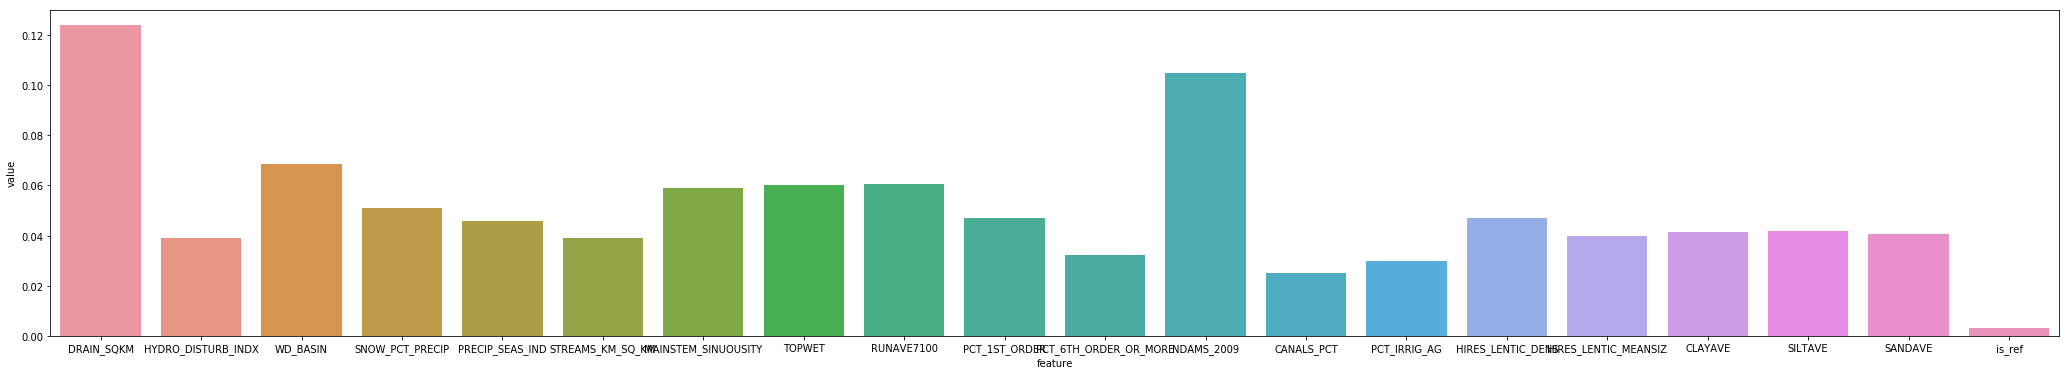

In [22]:
plt.figure(figsize=(36,6))
sns.barplot(x='feature', y='value', data=feature_imp)

In [10]:
y_pred = clf.predict(test_features)

In [11]:
from sklearn import metrics

In [16]:
print(metrics.classification_report(test_labels,y_pred))

              precision    recall  f1-score   support

         bad       0.84      0.95      0.89     22208
        good       0.79      0.54      0.64      8389

   micro avg       0.83      0.83      0.83     30597
   macro avg       0.82      0.74      0.77     30597
weighted avg       0.83      0.83      0.82     30597

